In [1]:
import json
import os
from pathlib import Path
import time
import copy

import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from fastai.dataset import open_image
import json
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import cv2
from tqdm import tqdm

In [2]:
# params
SIZE = 224
EPOCHS = 5
BATCH_SIZE = 32
NUM_WORKERS = 4
SHOW_IMAGES = False

# static
IMAGES = 'images'
ANNOTATIONS = 'annotations'
CATEGORIES = 'categories'
ID = 'id'
NAME = 'name'
IMAGE_ID = 'image_id'
BBOX = 'bbox'
CATEGORY_ID = 'category_id'
FILE_NAME = 'file_name'
IMAGE = 'image'
CATEGORY = 'category'
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

In [245]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print('device:', device)

device: cpu


In [4]:
!ls ../input/pascal/pascal

Annotations  SegmentationClass	 pascal_test2007.json	tmp
ImageSets    SegmentationObject  pascal_train2007.json
JPEGImages   models		 pascal_val2007.json


In [5]:
PATH = Path('../input/pascal/pascal')
list(PATH.iterdir())

[PosixPath('../input/pascal/pascal/tmp'),
 PosixPath('../input/pascal/pascal/SegmentationObject'),
 PosixPath('../input/pascal/pascal/pascal_train2007.json'),
 PosixPath('../input/pascal/pascal/Annotations'),
 PosixPath('../input/pascal/pascal/SegmentationClass'),
 PosixPath('../input/pascal/pascal/ImageSets'),
 PosixPath('../input/pascal/pascal/pascal_val2007.json'),
 PosixPath('../input/pascal/pascal/models'),
 PosixPath('../input/pascal/pascal/JPEGImages'),
 PosixPath('../input/pascal/pascal/pascal_test2007.json')]

In [6]:
train_data = json.load((PATH/'pascal_train2007.json').open())
val_data = json.load((PATH/'pascal_val2007.json').open())
test_data = json.load((PATH/'pascal_test2007.json').open())

print('train:', train_data.keys())
print('val:', val_data.keys())
print('test:', test_data.keys())

train: dict_keys(['images', 'type', 'annotations', 'categories'])
val: dict_keys(['images', 'type', 'annotations', 'categories'])
test: dict_keys(['images', 'type', 'annotations', 'categories'])


In [7]:
train_data[ANNOTATIONS][:1]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0}]

In [8]:
train_data[IMAGES][:2]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}]

In [9]:
len(train_data[CATEGORIES])

20

In [10]:
next(iter(train_data[CATEGORIES]))

{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'}

In [11]:
categories = {c[ID]:c[NAME] for c in train_data[CATEGORIES]}

# all categories are the same
val_categories = {c[ID]:c[NAME] for c in val_data[CATEGORIES]}
test_categories = {c[ID]:c[NAME] for c in test_data[CATEGORIES]}
assert categories == val_categories == test_categories

print('category count:', len(categories))
print(categories)

category count: 20
{1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle', 6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow', 11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person', 16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'}


In [12]:
IMAGE_PATH = Path(PATH/'JPEGImages/')
list(IMAGE_PATH.iterdir())[:2]

[PosixPath('../input/pascal/pascal/JPEGImages/000318.jpg'),
 PosixPath('../input/pascal/pascal/JPEGImages/006438.jpg')]

Helper functions for setting up `pandas.DataFrame` fed to the torch `Dataset`

In [13]:
def get_filenames(data):
    filenames = {o[ID]:o[FILE_NAME] for o in data[IMAGES]}
    print('get_id_filename_dict')
    print('length:', len(filenames), 'next item:', next(iter(filenames.items())))
    return filenames

In [14]:
def get_image_ids(data):
    image_ids = [o[ID] for o in data[IMAGES]]
    print('get_image_ids')
    print('length:', len(image_ids), 'next item:', image_ids[0])
    return image_ids

In [15]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

[196, 174]

In [16]:
def get_image_w_area(data, image_ids):
    image_w_area = {i:None for i in image_ids}
    image_w_area = copy.deepcopy(image_w_area)
    for x in data[ANNOTATIONS]:
        bbox = x[BBOX]
        new_category_id = x[CATEGORY_ID]
        image_id = x[IMAGE_ID]
        h, w = pascal_bb_hw(bbox)
        new_area = h*w
        cat_id_area = image_w_area[image_id]
        if not cat_id_area:
            image_w_area[image_id] = (new_category_id, new_area)
        else:
            category_id, area = cat_id_area
            if new_area > area:
                image_w_area[image_id] = (new_category_id, new_area)
    print('get_image_w_area')
    print('length:', len(image_w_area), 'next item:', next(iter(image_w_area.items())))
    return image_w_area

train data structs

In [17]:
train_filenames = get_filenames(train_data)
train_image_ids = get_image_ids(train_data)
train_image_w_area = get_image_w_area(train_data, train_image_ids)

get_id_filename_dict
length: 2501 next item: (12, '000012.jpg')
get_image_ids
length: 2501 next item: 12
get_image_w_area
length: 2501 next item: (12, (7, 34104))


try to locate the largest object's bbox

In [18]:
train_data[ANNOTATIONS][0]

{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
 'area': 34104,
 'iscrowd': 0,
 'image_id': 12,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0}

In [25]:
# {image_id: (area, [x1,y1,x2,y2], cat)} of largest obj
# data = train_data
# image_ids = train_image_ids

def get_image_w_bbox(data, image_ids):
    image_w_bbox = {i:None for i in image_ids}
    for x in data[ANNOTATIONS]:
        new_bbox = x[BBOX]
        new_category_id = x[CATEGORY_ID]
        image_id = x[IMAGE_ID]
        h, w = pascal_bb_hw(new_bbox)
        new_area = h*w
        existing = image_w_bbox[image_id]
        if not existing:
            image_w_bbox[image_id] = (new_area, new_bbox, new_category_id)
        else:
            area, *_, area = existing
            if new_area > area:
                image_w_bbox[image_id] = (new_area, new_bbox, new_category_id)
    return image_w_bbox

image_w_bbox = get_image_w_bbox(train_data, train_image_ids)

Image functions

In [ ]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

show image with bbox - using the above image functions

[155, 96, 196, 174]


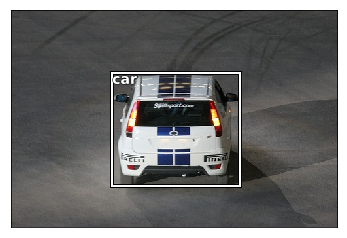

In [62]:
image_id, (area, bbox, cat) = next(iter(image_w_bbox.items()))
fn = f'{IMAGE_PATH}/{train_filenames[image_id]}'
im = open_image(fn)
ax = show_img(im)
b = bbox
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

In [63]:
def scale_pascal_bb(bbox, image, size):
    """
    Returns a bbox scaled to the target `size`
    
    Args:
        bbox (1d array): pascal_bb [x, y, x2, y2]
        image (3d array): HWC
        size (scalar): target image size that bbox should be scaled to
    """
    im_w = image.shape[1]
    im_h = image.shape[0]
    return np.multiply(np.divide(bbox, [im_w, im_h, im_w, im_h]), size)

[ 69.44     64.57658  87.808   117.04505]


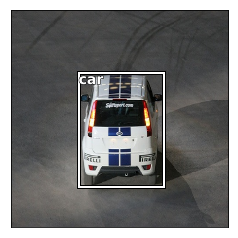

In [64]:
image_id, (area, bbox, cat) = next(iter(image_w_bbox.items()))
fn = f'{IMAGE_PATH}/{train_filenames[image_id]}'
im = open_image(fn)
resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
ax = show_img(resized_image)
size=224
b = scale_pascal_bb(bbox, im, size)
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

# Dataset

Scales image to (3, 224, 224) for Resnet18

Also scales the bbox

In [27]:
next(iter(train_filenames.items()))

(12, '000012.jpg')

In [28]:
 train_full_filenames = [
     (k, f'{IMAGE_PATH}/{v}')
  for k,v in train_filenames.items()]

In [29]:
tff = next(iter(train_full_filenames))
tff

(12, '../input/pascal/pascal/JPEGImages/000012.jpg')

In [30]:
open_image(tff[1]).shape

(333, 500, 3)

In [65]:
class BboxDataset(Dataset):
    def __init__(self, full_filenames, data_bbox):
        """
        Args:
            full_filenames (list): [(image_id, image_full_path), ...]
            data_bbox (dict): {image_id: (area, bbox, cat), ...}
        """
        self.full_filenames = full_filenames
        self.data_bbox = data_bbox

    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        image_id, image_path = self.full_filenames[idx]
        im = open_image(image_path) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        _, bbox, cat = self.data_bbox[image_id]
        scaled_bbox = scale_pascal_bb(bbox, im, SIZE)

        return image_id, image, (scaled_bbox, cat)
#         image_id, image, label = self.get(idx)
#         return image, label
    
#     def get(self, idx):
#         image_id, image_path = self.full_filenames[idx]
#         im = open_image(image_path) # HW
#         resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
#         image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
#         _, bbox, cat = self.data_bbox[image_id]
#         scaled_bbox = scale_pascal_bb(bbox, im, SIZE)

#         return image_id, image, (scaled_bbox, cat)
        
    
dataset = BboxDataset(train_full_filenames, image_w_bbox)
idx = 0
image_id, inputs, label = dataset[0]
# print('label:', label, 'shape:', inputs.shape)

In [154]:
hasattr(dataset, '_get')

False

In [67]:
inputs.shape

(3, 224, 224)

In [68]:
label

(array([ 69.44   ,  64.57658,  87.808  , 117.04505]), 7)

[ 69.44     64.57658  87.808   117.04505]


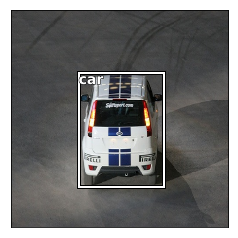

In [71]:
(bbox, cat) = label
ax = show_img(np.transpose(inputs, (1, 2, 0)))
b = bbox
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

### Val Dataset

In [72]:
# dataset = BboxDataset(train_full_filenames, image_w_bbox)

val data structs

In [73]:
val_filenames = get_filenames(val_data)
val_image_ids = get_image_ids(val_data)
val_image_w_area = get_image_w_area(val_data, val_image_ids)

get_id_filename_dict
length: 2510 next item: (5, '000005.jpg')
get_image_ids
length: 2510 next item: 5
get_image_w_area
length: 2510 next item: (5, (9, 9701))


In [95]:
def get_full_filenames(id_filename_dict):
    return [
         (k, f'{IMAGE_PATH}/{v}')
      for k,v in id_filename_dict.items()]
    
val_full_filenames = get_full_filenames(val_filenames)
next(iter(val_full_filenames))

(5, '../input/pascal/pascal/JPEGImages/000005.jpg')

In [97]:
preview_data(val_filenames)

(5, '000005.jpg')

In [99]:
val_data[ANNOTATIONS][0]

{'segmentation': [[262, 210, 262, 339, 324, 339, 324, 210]],
 'area': 7998,
 'iscrowd': 0,
 'image_id': 5,
 'bbox': [262, 210, 62, 129],
 'category_id': 9,
 'id': 1,
 'ignore': 0}

In [82]:
val_image_w_bbox = get_image_w_bbox(val_data, val_image_ids)
next(iter(val_image_w_bbox.items()))

(5, (1260, [276, 185, 36, 35], 9))

`preview_data` utility function

In [103]:
def preview_data(data):
    print(f'type: {type(data)}')
    if isinstance(data, (list, tuple)):
        return data[0]
    elif isinstance(data, dict):
        return next(iter(data.items()))
    else:
        raise TypeError(f"Unsupported type: {type(data)}")
        
print(preview_data(val_full_filenames))
print(preview_data(val_image_w_bbox))

type: <class 'list'>
(5, '../input/pascal/pascal/JPEGImages/000005.jpg')
type: <class 'dict'>
(5, (1260, [276, 185, 36, 35], 9))


In [143]:
val_dataset = BboxDataset(val_full_filenames, val_image_w_bbox)
idx = 2
image_id, inputs, label = val_dataset[idx]
image_id, inputs.shape, label

(9, (3, 224, 224), (array([115.136  , 117.67467,  17.92   ,  78.848  ]), 15))

In [144]:
label

(array([115.136  , 117.67467,  17.92   ,  78.848  ]), 15)

[115.136   117.67467  17.92     78.848  ]


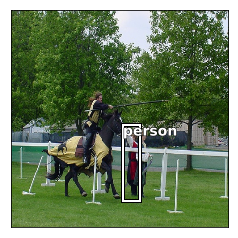

In [145]:
(bbox, cat) = label
ax = show_img(np.transpose(inputs, (1, 2, 0)))
b = bbox
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

show the above image for the ground truth to see if it's correct

In [107]:
image_id

5

In [138]:
idx = 2
image_id, filename = val_full_filenames[idx]
image_id, filename

(9, '../input/pascal/pascal/JPEGImages/000009.jpg')

In [139]:
area, bbox, cat = val_image_w_bbox[image_id]
area, bbox, cat

(5280, [257, 197, 40, 132], 15)

In [140]:
categories[cat]

'person'

In [141]:
im = open_image(filename)
im.shape

(375, 500, 3)

[257, 197, 40, 132]


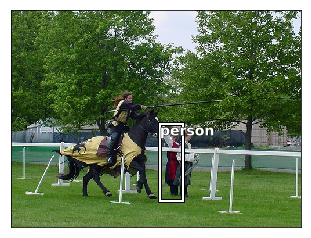

In [142]:
# (bbox, cat) = label
area, bbox, cat = val_image_w_bbox[image_id]
im = open_image(filename)
ax = show_img(im)
b = bbox
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[cat])

In [134]:
val_data[ANNOTATIONS][0]

{'segmentation': [[262, 210, 262, 339, 324, 339, 324, 210]],
 'area': 7998,
 'iscrowd': 0,
 'image_id': 5,
 'bbox': [262, 210, 62, 129],
 'category_id': 9,
 'id': 1,
 'ignore': 0}

test data structs

In [ ]:
test_filenames = get_filenames(test_data)
test_image_ids = get_image_ids(test_data)
test_image_w_area = get_image_w_area(test_data, test_image_ids)

train data structs (Legacy)

In [ ]:
train_filenames = {o[ID]:o[FILE_NAME] for o in train_data[IMAGES]}
print('length:', len(train_filenames))
image1_id, image1_fn = next(iter(train_filenames.items()))
image1_id, image1_fn

In [ ]:
train_image_ids = [o[ID] for o in train_data[IMAGES]]
print('length:', len(train_image_ids))
train_image_ids[:BATCH_SIZE]

In [ ]:
IMAGE_PATH

In [ ]:
image1_path = IMAGE_PATH/image1_fn
image1_path

In [ ]:
str(image1_path)

In [ ]:
im = open_image(str(IMAGE_PATH/image1_fn))
print(type(im))

In [ ]:
im.shape

In [ ]:
len(train_data[ANNOTATIONS])

In [ ]:
# get the biggest object label per image

In [ ]:
train_data[ANNOTATIONS][0]

In [ ]:
bbox = train_data[ANNOTATIONS][0][BBOX]
bbox

In [ ]:
def fastai_bb(bb):
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

print(bbox)
print(fastai_bb(bbox))

In [ ]:
fbb = fastai_bb(bbox)
fbb

In [ ]:
def fastai_bb_hw(bb):
    h= bb[3]-bb[1]+1
    w = bb[2]-bb[0]+1
    return [h,w]

fastai_bb_hw(fbb)

In [ ]:
def pascal_bb_hw(bb):
    return bb[2:]

bbox = train_data[ANNOTATIONS][0][BBOX]
pascal_bb_hw(bbox)

show image training example

In [21]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [22]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [23]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [24]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [ ]:
ax = show_img(im)
image1_ann = train_data[ANNOTATIONS][0]
b = image1_ann[BBOX]
print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], categories[image1_ann[CATEGORY_ID]])

Pandas DataFrames

In [ ]:
# TRAIN - create a Pandas dataframe for: image_id, filename, category
train_df = pd.DataFrame({
    IMAGE_ID: image_id,
    IMAGE: str(IMAGE_PATH/image_fn),
    CATEGORY: train_image_w_area[image_id][0]
} for image_id, image_fn in train_filenames.items())

print('count:', len(train_df))
print(train_df.iloc[0])
train_df.head()

In [ ]:
# VAL - create a Pandas dataframe for: image_id, filename, category
val_df = pd.DataFrame({
    IMAGE_ID: image_id,
    IMAGE: str(IMAGE_PATH/image_fn),
    CATEGORY: val_image_w_area[image_id][0]
} for image_id, image_fn in val_filenames.items())

print('count:', len(val_df))
print(val_df.iloc[0])
val_df.head()

In [ ]:
# NOTE: won't work in Kaggle Kernal b/c read-only file system
# BIGGEST_OBJECT_CSV = '../input/pascal/pascal/tmp/biggest-object.csv'
# train_df.to_csv(BIGGEST_OBJECT_CSV, index=False)

subclass Dataset

In [ ]:
class BiggestObjectDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im = open_image(self.df.iloc[idx][IMAGE]) # HW
        resized_image = cv2.resize(im, (SIZE, SIZE)) # HW
        image = np.transpose(resized_image, (2, 0, 1)) # CHW
        
        category =  self.df.iloc[idx][CATEGORY]

        return image, category
    
dataset = BiggestObjectDataset(train_df)
inputs, label = dataset[0]
print('label:', label, 'shape:', inputs.shape)

# DataLoader

In [167]:
BATCH_SIZE = 64
NUM_WORKERS = 0

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=True, num_workers=NUM_WORKERS)

batch_image_ids, batch_inputs, batch_labels = next(iter(dataloader))
# item = next(iter(dataloader))

In [173]:
batch_inputs.size()

torch.Size([64, 3, 224, 224])

In [174]:
# batch_labels is a list, the first item is the "batch bbox's", 2nd item is "batch categories"

In [170]:
len(batch_labels)

2

In [171]:
batch_labels[0].size()

torch.Size([64, 4])

In [172]:
batch_labels[1].size()

torch.Size([64])

In [ ]:
# train the model

In [176]:
NUM_CATEGORIES = len(categories)
NUM_CATEGORIES

20

In [178]:
model_ft = models.resnet18(pretrained=True)

for layer in model_ft.parameters():
    layer.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
IN_FEATURES = num_ftrs
print(IN_FEATURES, NUM_CATEGORIES)

# model_ft.fc = nn.Linear(num_ftrs, NUM_CATEGORIES)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

512 20


# Custom head with single Layer fork to 2 outputs

`[bbox preds, category preds]`

In [202]:
class BboxAndCatLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.cat_layer = nn.Linear(IN_FEATURES, NUM_CATEGORIES)
        self.bbox_layer = nn.Linear(IN_FEATURES, 4)
        
    def forward(self, x):
        return (self.bbox_layer(x), self.cat_layer(x), )
    
model_ft.fc = BboxAndCatLayer()

In [250]:
image_ids, inputs, labels = next(iter(dataloader))

In [251]:
print(len(labels))
print(type(labels))
print(labels[0].size())
print(labels[0].dtype)
print(labels[1].size())
print(labels[1].dtype)

2
<class 'list'>
torch.Size([64, 4])
torch.float64
torch.Size([64])
torch.int64


In [216]:
(bbox_labels, cat_labels) = labels

In [217]:
inputs.shape

torch.Size([64, 3, 224, 224])

In [205]:
bbox_labels.size()

torch.Size([64, 4])

In [206]:
cat_labels.size()

torch.Size([64])

In [207]:
outputs = model_ft(inputs)

In [208]:
type(outputs)

tuple

In [209]:
len(outputs)

2

In [210]:
type(outputs[0]), type(outputs[1])

(torch.Tensor, torch.Tensor)

In [211]:
outputs[0].size()

torch.Size([64, 4])

In [212]:
outputs[1].size()

torch.Size([64, 20])

In [239]:
bbox_outputs, cat_outputs = outputs
bbox_outputs.size(), cat_outputs.size()

(torch.Size([64, 4]), torch.Size([64, 20]))

In [225]:
_, cat_preds = torch.max(cat_outputs, dim=1)
cat_preds.size()

torch.Size([64])

In [240]:
preds = [bbox_outputs, cat_outputs]

print(preds[0].size())
print(preds[0].dtype)
print(preds[1].size())
print(preds[1].dtype)

torch.Size([64, 4])
torch.float32
torch.Size([64, 20])
torch.float32


# Loss Function - for custom head

In [246]:
class BboxAndCatLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bbox_loss = nn.L1Loss()
        self.cat_loss = nn.CrossEntropyLoss()
        
    def forward(self, preds, targets):
        bbox_preds, cat_preds = preds
        bbox_targets, cat_targets = targets

        # data munging
        bbox_preds = bbox_preds.to(device, torch.float64)
        cat_targets_0_indexed = cat_targets - 1
        
        # per type of loss
        bbox_loss = self.bbox_loss(bbox_preds, bbox_targets)
        cat_loss = self.cat_loss(cat_preds, cat_targets_0_indexed)
        # cast b/c bbox_loss.dtype == torch.float64
        cat_loss = cat_loss.to(device, dtype=torch.float64)
        
        return bbox_loss + cat_loss
    
criterion = BboxAndCatLoss()
loss = criterion(preds, labels)
loss

tensor(91.2455, dtype=torch.float64, grad_fn=<ThAddBackward>)

# Train the model

In [247]:
# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [254]:
epoch_losses = []
epoch_accuracies = []

for epoch in tqdm(range(EPOCHS)):
    print('epoch:', epoch)
    running_loss = 0.0
    running_correct = 0

    for image_ids, inputs, labels in dataloader:
        inputs = inputs.to(device)
        
        # labels
        (bbox_labels, cat_labels) = labels
        bbox_labels = bbox_labels.to(device)
        cat_labels = cat_labels.to(device)

        # clear gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model_ft(inputs)
        bbox_outputs, cat_outputs = outputs
        _, preds = torch.max(cat_outputs, dim=1)
        loss = criterion(outputs, labels)
        
        # backwards pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        labels_0_indexed = cat_labels - 1
        running_correct += torch.sum(preds == labels_0_indexed)
        break
    break
        
    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_correct.double().item() / len(dataset)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_acc)
    print('loss:', epoch_loss, 'acc:', epoch_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0


In [255]:
epoch_loss = running_loss / len(dataset)
epoch_acc = running_correct.double().item() / len(dataset)
epoch_losses.append(epoch_loss)
epoch_accuracies.append(epoch_acc)
print('loss:', epoch_loss, 'acc:', epoch_acc)

loss: 2.2005389636705956 acc: 0.0007996801279488205


In [ ]:
# epoch - w/ train and val

In [ ]:
# epoch_loss = {'train': np.inf, 'val': np.inf}
# epoch_acc = {'train': 0, 'val': 0}

# epoch_losses = {'train': [], 'val': []}
# epoch_accuracies = {'train': [], 'val': []}

# for epoch in tqdm(range(EPOCHS)):
#     print('epoch:', epoch)

#     for phase in ['train', 'val']:
#         if phase == 'train':
#             model_ft.train()
#         else:
#             model_ft.eval()

#         running_loss = 0.0
#         running_correct = 0

#         for inputs, labels in dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # clear gradients
#             optimizer.zero_grad()

#             with torch.set_grad_enabled(phase == 'train'):
#                 # forward pass
#                 outputs = model_ft(inputs)
#                 _, preds = torch.max(outputs, dim=1)
#                 labels_0_indexed = labels - 1
#                 loss = criterion(outputs, labels_0_indexed)

#                 # backwards pass
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_correct += torch.sum(preds == labels_0_indexed)

#         epoch_acc[phase] = running_correct.double().item() / len(dataset)
#         epoch_loss[phase] = running_loss / len(dataset)
#         # running sums
#         epoch_losses[phase].append(epoch_loss[phase])
#         epoch_accuracies[phase].append(epoch_acc[phase])
#     print('phase', phase, 'train loss:', epoch_loss['train'], 'train acc:', epoch_acc['train'], 'val loss:', epoch_loss['val'], 'val acc:', epoch_acc['val'])

Graph loss and accuracy

In [ ]:
epoch_losses

In [ ]:
epoch_accuracies

In [ ]:
# check predictions

In [ ]:
plt.plot(epoch_losses['train'])
plt.plot(epoch_losses['val'])

In [ ]:
plt.plot(epoch_accuracies['train'])
plt.plot(epoch_accuracies['val'])

In [ ]:
preds_count = len(preds)
fig, axes = plt.subplots(1, preds_count, figsize=(16, 16))
for i, ax in enumerate(axes.flat):
    im = np.transpose(inputs[i], (1, 2, 0))
    ax = show_img(im, ax=ax)
    draw_text(ax, (0,0), categories[preds[i].item()+1])

In [ ]:
categories

In [ ]:
preds

In [ ]:
preds[0]+1

In [ ]:
inputs = inputs.to(device)
labels = labels.to(device)

In [ ]:
outputs = model_ft(inputs)
_, preds = torch.max(outputs, dim=1)
labels_0_indexed = labels - 1

In [ ]:
torch.sum(labels_0_indexed == preds)

In [ ]:
labels_0_indexed[0]

In [ ]:
preds[0]

In [ ]:
categories[2]

In [ ]:
inputs[0].shape

In [ ]:
# plt.imshow(np.transpose(inputs[0], (1, 2, 0)))

In [ ]:
labels

In [ ]:
labels-1

In [ ]:
criterion(outputs, labels-1)

In [ ]:
torch.sum(preds == labels)

In [ ]:
a = torch.Tensor([1, 2])
b = torch.Tensor([1, 3])
torch.sum(a == b)

In [ ]:
t = torch.randn(2, 3)
torch.max(t, dim=1)

In [ ]:
inputs.shape

In [ ]:
to_nchw(inputs).shape

In [ ]:
train_df.iloc[0]

In [ ]:
image1_filename = train_df.iloc[0][IMAGE]
image1_filename

In [ ]:
im = cv2.imread(image1_filename)

In [ ]:
im.shape

In [ ]:
im = cv2.imread(image1_filename, 0)
im.shape

In [ ]:
np.array([im]).shape

In [ ]:
im.shape

In [ ]:
type(im)

In [ ]:
cv2.resize()

In [ ]:
import cv2
SIZE = 224
resized_im = cv2.resize(im, (SIZE, SIZE))
plt.imshow(resized_im)

In [ ]:
resized_im = cv2.resize(im, (SIZE, SIZE))
plt.imshow(resized_im)

In [ ]:
scaled_item = scale(item[IMAGE], item[CATEGORY])
len(scaled_item) 

In [ ]:
scaled_x, scaled_y = scaled_item
scaled_x.shape

In [ ]:
scaled_y

In [ ]:
train_df.iloc[0]

In [ ]:
def show_random_image():
    item = dataset[np.random.randint(0, 100)]
    print(categories[item[CATEGORY]])
    plt.imshow(item[IMAGE])

show_random_image()

In [ ]:
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)

next(iter(dataloader))

In [ ]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloader))

In [ ]:
# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [ ]:
classes

In [ ]:
train_filenames

In [ ]:
train_image_w_area

In [ ]:
# object classification

In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
for layer in model.parameters():
    layer.requires_grad = False

In [ ]:
fc_in_features = model.fc.in_features
fc_in_features

In [ ]:
model.fc = nn.Linear(fc_in_features, len(categories))

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# need to read images with "skimage" or "cv2" and do DataSet / DataLoader config first before running model

In [ ]:
from skimage import io

In [ ]:
image0 = io.imread(list(IMAGE_PATH.iterdir())[0])
image0.shape